# Overview

**rtmod** is a python repository for approximating the route modulus for directed, simple graphs. The packages in this repository are dependent on *igraph* and *numpy*, so if you have not already, install them by running the appropriate pip commands.


This notebook is meant to be a comprehensive overview of the main functionality of the packages in rtmod, how they work, and how to use them. Specifically, we will review the methods of the mfrpy and pmodpy packages.

## Motivation
Conventional shortest-path algorithms are extremely refined and efficient. However, they are not necessarily applicable to the modeling of all types of networks. Cell signal transduction networks constitute one such example. In these instances, connections between subcomponents can be represented as directed edges, but there is no standardized representation for certain relationships between components, specifically those of conditional dependence of some components on others (synergy) and the inhibitory actions of components on the network. Taking these notions into account, our interest shifts from finding the shortest path from a source node to a target node to obtaining a collection of *minimal functional routes* by which a signal can travel from source to target, given the relationships between vertices in the network. One of the core aims of this project is capturing these important relationships graphically in order to better represent these important systems. In order to do this, we deal with *expanded graphs*, which are signal transduction networks that have been expanded (see below) to make computational algorithms more straightforward by requiring less annotation and fewer conditional steps along the way. We draw heavily from ideas presented by Reka Albert and colleagues at the University of Kansas, who have layed much of the theoretical groundwork for these concepts.

### Synergy
A regular (activating) connection between two components of a signal transduction network can be represented by a directed edge between two nodes on the graph of the network. But how can we capture the fact that some components are only activated when two (or more) of its predecessors are activated in tandem? This is where the concept of synergy comes in. When the activation of a component is conditionally dependent on the simultaneous activation of several other components, the component's corresponding node on the graph is said to have a synergistic set of predeccessors consisting of precisely the nodes of the conditional components. Alternatively, we can say that the edges between these nodes have the same synergy value, which is the method by which this charecteristic is employed in the actual algorithm. 

### Inhibition
It is often the case in practical cell transduction networks that one component inhibits the activation of another. This too, can be captured graphically. A certain node can be inhibited by one of its predeccessors, so instead of drawing an activating edge between them we might want to consider calling the edge between them inhibitory. More generally, we can map every edge of the graph to the binary group, so that every edge mapped to 1 is considered inhibitory and all others are normall activating edges.

### Theoretical Work
How do we represent attributes such as synergy and inhibition graphically? One way we may try is by adding new conventions, such as dashed and barred edges, but this is largely unintuitive and can lead to ambiguity and confusion. Instead, we can transform the entire graph with the appropriate attributes into an "expanded" version of itself - a directed graph with only activating edges but with no ambiguity as to what components are synergistic and which are inhibitory. This is done by introducing new vertices: composite and inhibitory nodes. Composite nodes link a conditionally dependent node to its synergistic set of predecessors, while inhibitory nodes are activated when one component inhibits another. For example, if A inhibits B, we can also say that NOT A activates B AND A activates NOT B. By employing these tricks we can circumvent possible confusion and create programs which are capable of working with these notions.

### Practical Networks
To illustrate the full functionality, we will implement the package on several real-world networks, including...

## mfrpy

mfrpy is a package for calculating the minimal functional routes of a given graph. 

### igraph objects
The igraph package encodes graphs as operable python objects. Edges and vertices are encoded in lists, making it possible to iteritavely attach attributes to each element based on certain criteria. To familiarize ourselves with the format, we can initialize an example graph:


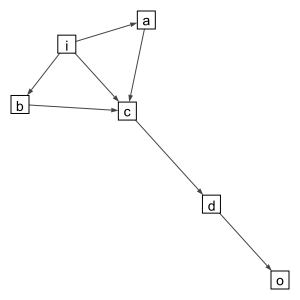

In [56]:
import igraph
test = igraph.Graph(directed = True)
test.add_vertices(6)
test.add_edges(
[(0,1), (0,2), (0,3), (1,3), (2,3), (3,4), (4,5)]
)
test.vs["name"] = ["i", "a", "b", "c", "d", "o"]
test.vs["label"] = test.vs["name"]
layout = test.layout_circle
igraph.plot(test, vertex_size = 18, vertex_shape = "square", edge_arrow_size = 0.5, vertex_color = "white", bbox=(0, 0, 300, 300))

Our test graph is a directed cyclic graph on 6 labeled vertices. Given prior knowledge of the network this graph represents, we can include synergy and inhibition quite easily by attaching the appropriate attributes to the edge sequence. Here, synergistic edges are colored blue.

edge syn inhibitory
i -> a 0 False
i -> b 0 False
i -> c 0 True
a -> c 1 True
b -> c 1 True
c -> d 0 True
d -> o 0 False


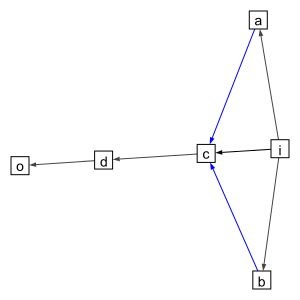

In [74]:
test.es["synergy"] = [0, 0, 0, 1, 1, 0, 0]
test.es["inhibition"] = [0, 0, 1, 1, 1, 1, 0]

print("edge", "syn", "inhibitory")
for edge in test.get_edgelist():
    print(test.vs[edge[0]]["name"], "->", test.vs[edge[1]]["name"], test.es[test.get_edgelist().index(edge)]["synergy"], bool(test.es[test.get_edgelist().index(edge)]["inhibition"]))
    
test.es.select(_source_in=[1,2], _target_in=[3])["color"] = "blue"
layout = test.layout_circle
igraph.plot(test, vertex_size = 18, vertex_shape = "square", edge_arrow_size = 0.5, vertex_color = "white", bbox=(0, 0, 300, 300))

### update_expand.py

This is a collection of methods for generating boolean update tables for the input graph, and converting these input tables into an expanded graph with composite nodes and logical NOT nodes to capture the behaviors of synergistic and inhibitory edges. We first obtain an update table with a zero-order logical expression for every node in the graph. The source node will always have an empty expressions since it lacks predecessors:

In [83]:
from mfrpy import update_expand
table = update_expand.updates(test, test.es["synergy"], test.es["inhibition"])
for target in table[0]:
    print(target, "=", table[1][test.vs["name"].index(target)])

i = 
a = i
b = i
c = ~i|~a&~b
d = ~c
o = d


We can now use this table to accurately expand our graph with the considerations of synergy and inhibition. Here, '~' is the logical NOT, whereas '&' and '|' are the logical AND and OR respectively. The drawback of doing this process graph-theoretically is the challenge of handling edges which have both attributes, as it is not always clear which expansion to perform first. By computing via the update table, there is no ambiguity and both attributes are expanded in tandem. We can now expand the test graph by running

IGRAPH DN-- 17 11 --
+ attr: composite (v), name (v)
+ edges (vertex names):
i->a, i->b, d->o, ~i->c, ~a->~i, ~b->~i, ~c->d, i->~c, a->~c, b->~c, c->~d


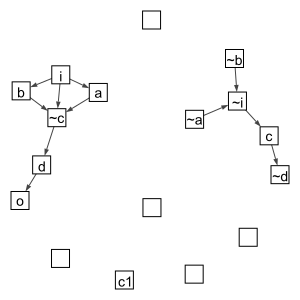

In [90]:
exp_test = update_expand.expand(test, table)
print(exp_test)
exp_test.vs["label"] = exp_test.vs["name"]
layout = exp_test.layout_circle
igraph.plot(exp_test, vertex_size = 18, vertex_shape = "square", edge_arrow_size = 0.5, vertex_color = "white", bbox=(0, 0, 300, 300))

### sgmfr.py

This is a method for calculating the minimal functional routes of an expanded graph provided by **update_expand**. The method uses a top-down subgraph-growing algorithm to generate minimal functional routes in the expanded graph. starting from a target node, the algorithm examines its predecessors. If there are no composite nodes, it proceeds by adding predecessors one at a time until it reaches the source node, at which point it will pursue a different chain of predecessors, much like a normal shortest-path algorithm. However, if it encounters a composite node, the method appends all of the nodes predecessors as one synergistic set in the minimal functional route. To avoid redundancy that may occur from cyclic graphs, cycles are cleaved after all minimal functional routes are generated.

## pmodpy